# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [2]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [5]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [6]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [7]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926486
Test score: 0.4010466305154149


In [8]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


In [9]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


# 以降にコードを追加

相関を見ておく

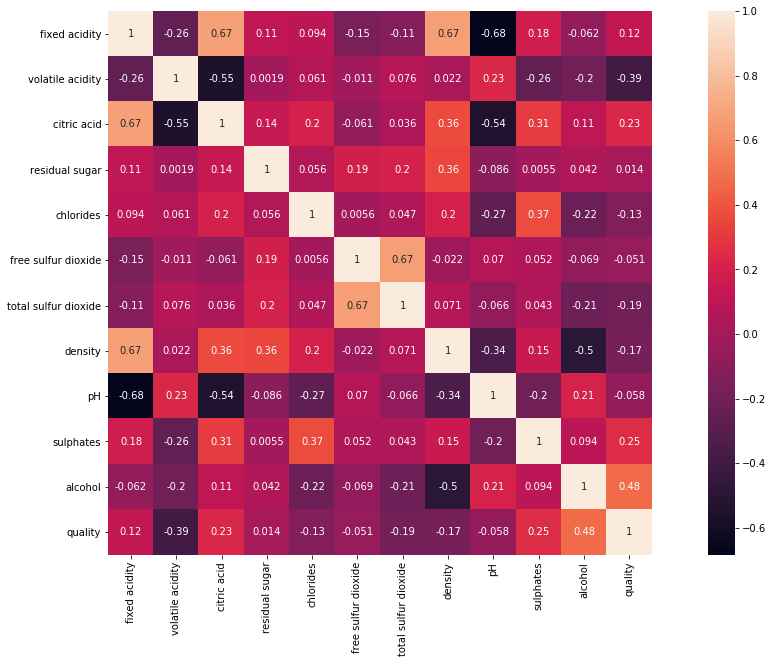

In [18]:
import seaborn
corr = wine_quality_df.corr()
plt.figure(figsize=(20, 10))
seaborn.heatmap(corr,square=True, annot=True)

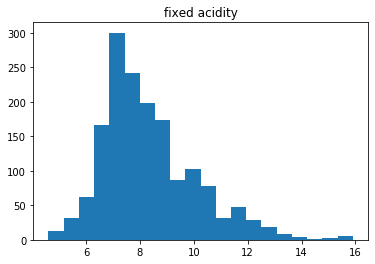

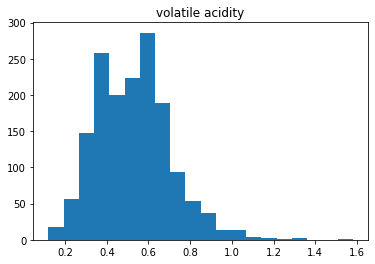

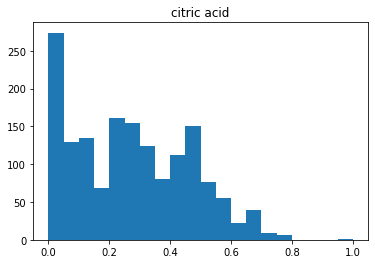

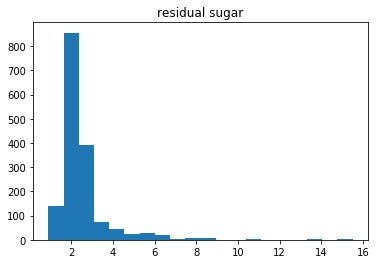

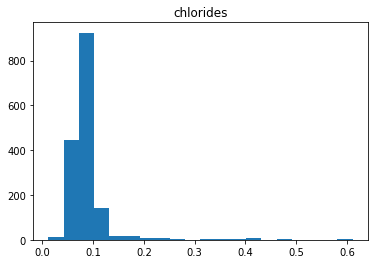

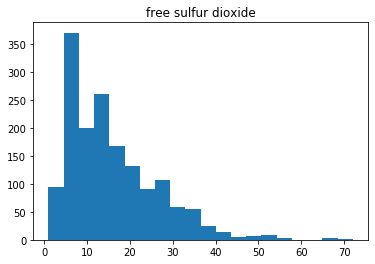

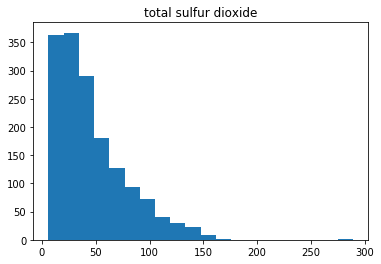

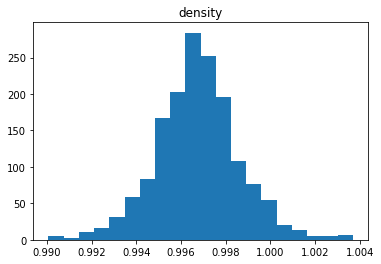

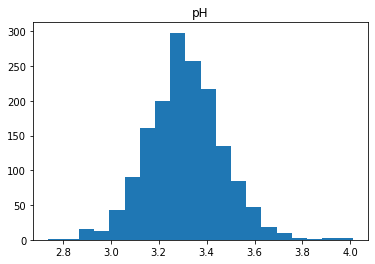

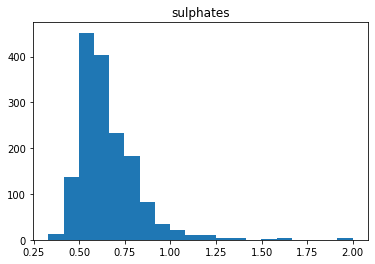

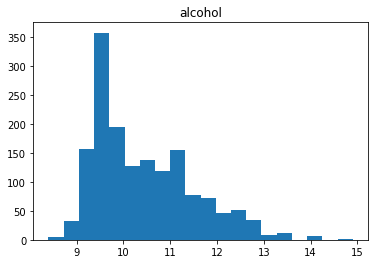

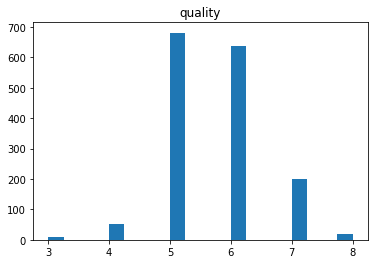

In [16]:
import matplotlib.pyplot as plt
for f_name in wine_quality_df.columns:
    plt.figure()
    plt.hist(wine_quality_df[f_name],bins=20)
    plt.title(f_name)

一部外れ値が存在


標準化によるスコアの変化

In [13]:
from sklearn import preprocessing
ss = preprocessing.StandardScaler()
wine_quality_df_ss = pd.DataFrame(ss.fit_transform(wine_quality_df),columns=wine_quality_df.columns)

X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df_ss[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.4517534  0.42304089 0.37989962 0.42790546 0.3492721 ]
Average score: 0.40637429442805406
Test score: 0.38775879023533444


ある程度外れ値除去し，標準化した結果

In [30]:
data = pd.read_csv("winequality-red.csv",delimiter=";")


wine_data = data[data['fixed acidity'] < 15]
wine_data = wine_data[wine_data['volatile acidity'] < 1.3]
wine_data = wine_data[wine_data['citric acid'] < 0.8]
wine_data = wine_data[wine_data['citric acid'] < 0.8]
wine_data = wine_data[wine_data['residual sugar'] < 7]
wine_data = wine_data[wine_data['chlorides'] < 0.2]
wine_data = wine_data[wine_data['free sulfur dioxide'] < 45]
wine_data = wine_data[wine_data['total sulfur dioxide'] < 200]
wine_data = wine_data[wine_data['sulphates'] < 1.35]
wine_data = wine_data[wine_data['alcohol'] < 14]

wine_data_ss = pd.DataFrame(ss.fit_transform(wine_data),columns=wine_quality_df.columns)

X_train, X_test, y_train, y_test = \
    train_test_split(wine_data_ss[feature_names], wine_data["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.34633121 0.37209354 0.45689525 0.41574387 0.34674838]
Average score: 0.3875624506476044
Test score: 0.36682630177484427


少しスコアが良くなった